# Analisis Exploratorio de Datos de PE La Castellana

In [1]:
import sys 
print(sys.version)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (21,7), 'figure.dpi':120})
%matplotlib inline

## meteostat
from datetime import datetime, timedelta
from meteostat import Hourly
from meteostat import Point, Daily
from meteostat import Stations


##mis funciones
#from datetime import timedelta #si no se define dentro de la funcion arroja error
from clean_data import remover_valores_repetidos
from clean_data import rango_fechas_repe
from clean_data import rango_fechas_repe_exc
from clean_data import weighted_circular_mean

from smec_energy import calcular_energia_lcas,smec_data

El dataset que se va a trabajar corresponde al Parque Eólico La Castellana ubicado en Bahia Blanca, Buenos Aires, Argentina.

In [3]:
#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/Datos_LAC_SOTR_2019_2024_horario.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\Datos_LAC_SOTR_2019_2024_horario.csv'


data_types = {          
    'TotPwrWTGs': float        
    ,'Nro_Available_WTGs': float
    ,'VelViento': float
    ,'DirVientoPond': float
    ,'Temp': float
    ,'HumedadRel': float
    ,'PresionAtm': float
    ,'ENERGIA_SMEC': float
    ,'ENERGIA_PRON_CAMMESA': float
    ,'ERROR_PRONOSTICO': float
}


df = pd.read_csv(path, dtype=data_types, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S.%f', delimiter=';', header=0)


#da error al leer el csv para los campo que tienen el punto como separador de miles (converti el formato del a nuemero 
#para columnas PresionAtm y ERROR_PRONOSTICO), en el excel formatear estas columnas en personalizado standard

#### Descripción del dataset
Este dataset corresponde a los datos producción de generación de energia y los meteorológicos del parque eólico La Castellana ubicado en Bahia Blanca provincia de Buenos Aires, Argentina. El parque tiene una potencia instalada de 100 Mw.

El dataset cuenta con datos desde Enero del 2019 a la actualidad.  


#### Descripción de las variables del dataset
* TotPwrWTGs: Es la suma de la energia horaria generada por cada turbina del parque. Fuente sistema Scada del parque        
* Nro_Available_WTGs: Es un contador de turbinas que estan en un estado de indisponibilidad, se infiere este estado por estar consumiendo energia auxiliar (valores de potencia en 0 o negativos)
* VelViento: Velocidad promedio del viento horaria. Fuente Estación meteorologica del parque. 
* DirVientoPond: Dirección del viento horaria promedio ponderado con la velocidad del viento.   
* Temp: Temperatura ambiente promedio horario. Fuente Estación meteorologica del parque.
* HumedadRel: Humedad promedio horaria. Fuente Estación meteorologica del parque.
* PresionAtm: Presion atmosféria horaria. Fuente Estación meteorologica del parque.   
* ENERGIA_SMEC: Es la energia horaria neta producida medida por el medidor de energia del parque. Es por la que remunera Cammesa o el cliente. Es un poco menor que la TotPwrWTGs por que resta la energia auxiliar consumida por la propia planta para producir.   
* ENERGIA_PRON_CAMMESA: Es la energia pronosticada por Cammesa que se va a producir en la planta. 
* ERROR_PRONOSTICO: Es el error del pronostico, diferencia entre ENERGIA_SMEC y ENERGIA_PRON_CAMMESA

Estas últimas 3 variables provienen de la base de datos de Cammesa y la ENERGIA_SMEC esta garantizado que es un dato de calidad por que se interroga directamente desde el medidor de energia y se utiliza para facturar.

In [4]:
#cambio nombre de las columnas


nom_colum = ['FechaHora','EnergiaTGW','AerosDisp','VelViento','DirViento','TempAmb','HumedadRel','PresionAtm','EnergiaSMEC','PronosticoCammesa','ErrorPronostico']

df.columns = nom_colum

df.tail()

,FechaHora,EnergiaTGW,AerosDisp,VelViento,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
46011,2024-04-01 04:00:00,23.68,25.00,0.25,54.44,13.77,63.78,1008.94,NaN,NaN,NaN
46012,2024-04-01 05:00:00,14.03,25.00,0.25,54.07,13.62,68.03,1008.39,NaN,NaN,NaN
46013,2024-04-01 06:00:00,8.88,26.00,0.25,39.52,14.03,66.71,1007.95,NaN,NaN,NaN
46014,2024-04-01 07:00:00,7.08,28.00,0.25,18.81,14.49,63.70,1007.76,NaN,NaN,NaN
46015,2024-04-01 08:00:00,6.13,29.00,0.25,15.88,14.93,56.56,1007.84,NaN,NaN,NaN
46016,2024-04-01 09:00:00,1.27,20.00,0.25,8.47,15.92,44.95,1008.51,NaN,NaN,NaN
46017,2024-04-01 10:00:00,-0.34,5.33,0.25,346.75,16.72,34.66,1009.57,NaN,NaN,NaN
46018,2024-04-01 11:00:00,-0.38,2.00,0.25,15.87,17.24,37.51,1010.74,NaN,NaN,NaN
46019,2024-04-01 12:00:00,-0.36,2.00,0.25,290.70,19.14,31.88,1011.52,NaN,NaN,NaN
46020,2024-04-01 13:00:00,-0.35,2.00,0.25,205.31,20.74,25.55,1011.65,NaN,NaN,NaN


#### Limpieza de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46051 entries, 0 to 46050
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FechaHora          46051 non-null  datetime64[ns]
 1   EnergiaTGW         43196 non-null  float64       
 2   AerosDisp          43222 non-null  float64       
 3   VelViento          43196 non-null  float64       
 4   DirViento          43196 non-null  float64       
 5   TempAmb            43196 non-null  float64       
 6   HumedadRel         43196 non-null  float64       
 7   PresionAtm         43196 non-null  float64       
 8   EnergiaSMEC        45888 non-null  float64       
 9   PronosticoCammesa  33024 non-null  float64       
 10  ErrorPronostico    33024 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 3.9 MB


#### Extracción de datos de energia desde API de Energia_SMEC para completar datos hasta la actualidad

In [12]:
# Filtro los registros con EnergiaSMEC igual a NaN, para obtener fecha minima
f_desde =  df[df['EnergiaSMEC'].isna()]['FechaHora'].min().date()
f_hasta = datetime.now().date()

#f_desde = "2024-03-26"
#f_hasta = "2024-03-28"

print("Min FechaHora for EnergiaSMEC NaN:", f_desde)
print("Max FechaHora for EnergiaSMEC NaN:", f_hasta)

result_df = calcular_energia_lcas(f_desde,f_hasta).iloc[:-1]
result_df.tail()

Min FechaHora for EnergiaSMEC NaN: 2024-03-27
Max FechaHora for EnergiaSMEC NaN: 2024-04-02


,FechaHora,LCASM61P,LCASM62P,LCA2M61P,EnergiaSMEC
112,2024-03-31 17:00:00,2585,2617,186,5.02
113,2024-03-31 18:00:00,5998,6610,393,12.22
114,2024-03-31 19:00:00,8427,10156,573,18.01
115,2024-03-31 20:00:00,12996,16156,924,28.23
116,2024-03-31 21:00:00,15192,19674,1039,33.83
117,2024-03-31 22:00:00,13824,20672,936,33.56
118,2024-03-31 23:00:00,12571,15753,876,27.45
119,2024-04-01 00:00:00,17133,17687,1332,33.49
120,2024-04-01 01:00:00,19526,21161,2200,38.49
121,2024-04-01 02:00:00,14181,20300,2248,32.23


In [14]:
# Set 'FechaHora' as index for both DataFrames
#df_clean.set_index('FechaHora', inplace=True)
df.set_index('FechaHora', inplace=True)
result_df.set_index('FechaHora', inplace=True)

# Concatenate df_clean and result_df
df = pd.concat([df, result_df['EnergiaSMEC']])

# Remove duplicate rows based on 'FechaHora' index
df = df[~df.index.duplicated(keep='first')]

# Update values in df_clean['EnergiaSMEC'] with values from result_df['EnergiaSMEC']
df.update(result_df['EnergiaSMEC'], overwrite=False)

# Reset index to make 'FechaHora' a column again
df.reset_index(inplace=True)



In [16]:
# Display the tail of the merged DataFrame
df.tail(5)

,FechaHora,EnergiaTGW,AerosDisp,VelViento,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
46046,2024-04-02 15:00:00,88.78,29.50,0.25,312.46,20.70,44.77,996.37,86.72,NaN,NaN
46047,2024-04-02 16:00:00,86.40,29.83,0.25,318.29,21.37,43.14,994.66,84.58,NaN,NaN
46048,2024-04-02 17:00:00,82.88,29.17,0.25,325.82,21.41,43.71,993.80,80.92,NaN,NaN
46049,2024-04-02 18:00:00,71.25,28.50,0.25,344.33,21.63,43.54,992.57,69.88,NaN,NaN
46050,2024-04-02 19:00:00,50.40,19.50,0.25,343.38,21.74,42.38,992.67,NaN,NaN,NaN


#### Verficación de valores nulos

In [17]:
df.isnull().sum()

FechaHora                0
EnergiaTGW            2855
AerosDisp             2829
VelViento             2855
DirViento             2855
TempAmb               2855
HumedadRel            2855
PresionAtm            2855
EnergiaSMEC              1
PronosticoCammesa    13027
ErrorPronostico      13027
dtype: int64

El valor a predecir es el de EnergiaSMEC, como se puede observar para las variables meteorológicas hay valores en null y ademas debo analizar la calidad de las variables meteorológicas para detectar inconsistencias. Esto implica que hubo un problema de comunicación con la estación meteorologica o con alguno de los sensores.  

In [18]:
df.dropna(subset=['EnergiaSMEC'], inplace=True)

#### Analisis de inconsistencias en variable meteorológicas

In [19]:
num_vars= nom_colum[1:9]
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,43195.0,48.591450,35.172565,-0.87,15.05,45.13,84.490,101.58
AerosDisp,43221.0,26.597987,7.892687,0.00,25.67,29.83,31.000,32.00
VelViento,43195.0,7.005744,4.137651,0.00,3.97,6.77,10.040,23.78
DirViento,43195.0,220.248427,105.151138,0.00,125.10,249.15,316.055,359.86
TempAmb,43195.0,13.366269,18.284546,-49.75,10.06,15.82,21.730,412.50
HumedadRel,43195.0,53.526439,50.645965,-55.52,29.73,47.39,67.855,394.40
PresionAtm,43195.0,971.072653,170.397182,0.00,999.71,1003.84,1007.990,1024.66
EnergiaSMEC,46050.0,47.717045,34.632443,-0.01,14.26,45.26,83.110,99.44


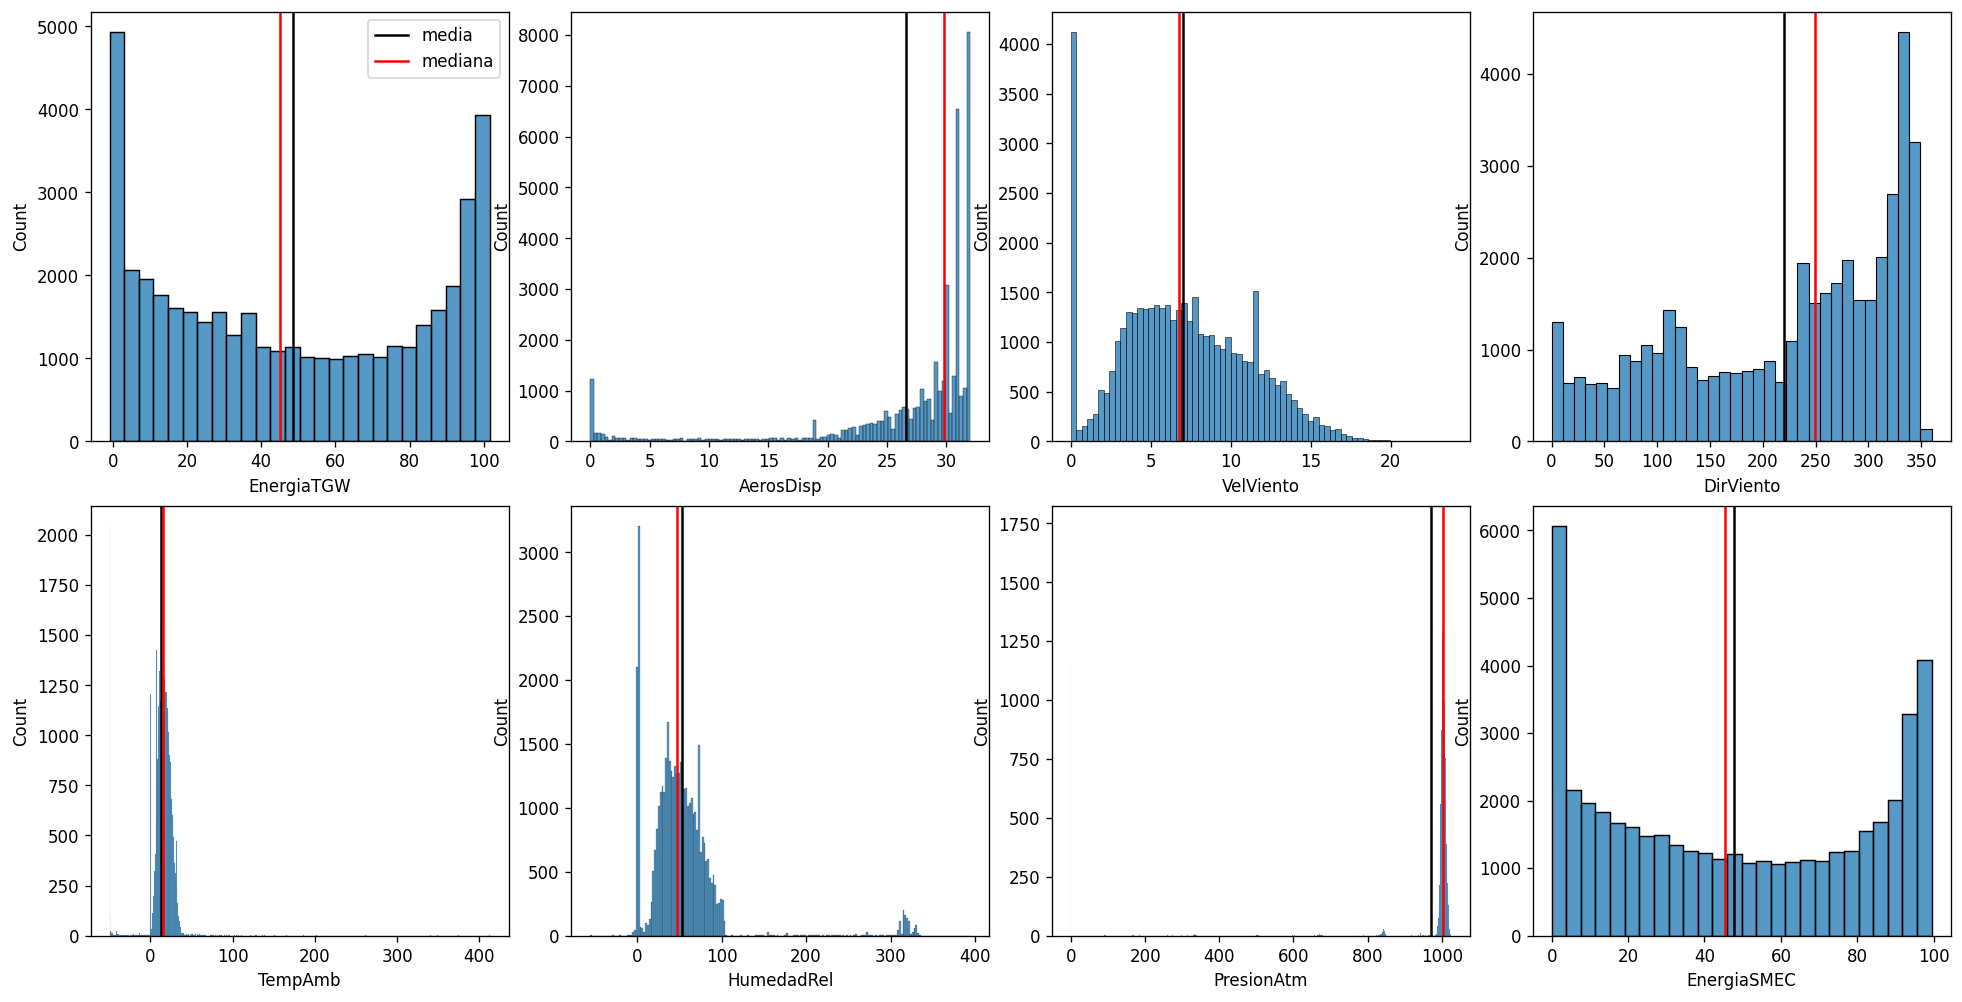

In [20]:
# Distribuciones para cada variable numerica
f, ax = plt.subplots(2, 4, figsize=(20, 10), gridspec_kw={'wspace': 0.15, 'hspace': 0.15})
ax = ax.ravel()

for i, col in enumerate(num_vars):
    sns.histplot(df[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=df[col].mean(), color='k', label='media')
    ax[i].axvline(x=df[col].median(), color='r', label='mediana')

# Turn off the last subplot if needed
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()

ax[0].legend()


In [21]:
df[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,43195.0,48.591450,35.172565,-0.87,15.05,45.13,84.490,101.58
AerosDisp,43221.0,26.597987,7.892687,0.00,25.67,29.83,31.000,32.00
VelViento,43195.0,7.005744,4.137651,0.00,3.97,6.77,10.040,23.78
DirViento,43195.0,220.248427,105.151138,0.00,125.10,249.15,316.055,359.86
TempAmb,43195.0,13.366269,18.284546,-49.75,10.06,15.82,21.730,412.50
HumedadRel,43195.0,53.526439,50.645965,-55.52,29.73,47.39,67.855,394.40
PresionAtm,43195.0,971.072653,170.397182,0.00,999.71,1003.84,1007.990,1024.66
EnergiaSMEC,46050.0,47.717045,34.632443,-0.01,14.26,45.26,83.110,99.44


Como se puede observar hay valores inconsistentes por los picos y outliers en todas las variables meteorológicas

#### Calculo de los promedios de las variables meteorológicas en base a la EnergiaSMEC
Calculos los valores promedio de las variables meteotológicas para valores discretizados con saltos de 0,5 MW de la variable EnergiaSMEC

Para calcular los valores promedio de las variables meteorológicas elimino los nulos y los valores inconsistentes, que distorcionan el calculo de la media

In [22]:
#variables meteorológicas
meteo_vars=['VelViento','DirViento','TempAmb','HumedadRel','PresionAtm']

In [23]:
#Borro los registros que tiene valor nulo
df_aux=df.dropna(subset=['EnergiaTGW'])


In [24]:
#Verifico que no quedan nulos
df_aux.isnull().sum()

FechaHora                0
EnergiaTGW               0
AerosDisp                0
VelViento                0
DirViento                0
TempAmb                  0
HumedadRel               0
PresionAtm               0
EnergiaSMEC              0
PronosticoCammesa    11994
ErrorPronostico      11994
dtype: int64

In [25]:
df_aux.reset_index(inplace=True, drop=True)
#df_aux.head()

In [26]:
#remuevo los registros que tiene valores repetidos para la VelViento durante 3 horas consecutivas
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'VelViento', 3,'y')

Se removieron 8655 registros repetidos
Remueve el valor 11.21 repetido 9 veces: 2019-05-05 00:00:00 - 2019-05-05 08:00:00
Remueve el valor 3.55 repetido 12 veces: 2019-05-07 21:00:00 - 2019-05-08 08:00:00
Remueve el valor 9.41 repetido 10 veces: 2019-05-09 00:00:00 - 2019-05-09 09:00:00
Remueve el valor 4.07 repetido 17 veces: 2019-05-09 18:00:00 - 2019-05-10 10:00:00
Remueve el valor 5.84 repetido 10 veces: 2019-05-10 19:00:00 - 2019-05-11 04:00:00
Remueve el valor 6.68 repetido 3 veces: 2019-05-11 06:00:00 - 2019-05-11 08:00:00
Remueve el valor 3.07 repetido 9 veces: 2019-05-20 17:00:00 - 2019-05-21 01:00:00
Remueve el valor 3.07 repetido 4 veces: 2019-05-21 05:00:00 - 2019-05-21 08:00:00
Remueve el valor 0.0 repetido 6 veces: 2019-05-22 03:00:00 - 2019-05-22 08:00:00
Remueve el valor 4.21 repetido 11 veces: 2019-05-30 00:00:00 - 2019-05-30 10:00:00
Remueve el valor 0.0 repetido 10 veces: 2019-05-30 15:00:00 - 2019-05-31 00:00:00
Remueve el valor 0.0 repetido 4 veces: 2019-05-31 05:0

In [27]:
df_aux.tail()

,FechaHora,EnergiaTGW,AerosDisp,VelViento,DirViento,TempAmb,HumedadRel,PresionAtm,EnergiaSMEC,PronosticoCammesa,ErrorPronostico
42121,2024-02-18 01:00:00,29.00,29.67,5.47,135.39,40.43,85.40,1009.17,29.28,63.02,115.26
42122,2024-02-18 02:00:00,13.18,29.33,3.77,129.38,34.72,87.12,1009.25,13.11,33.55,155.91
42123,2024-02-18 03:00:00,20.03,29.17,2.65,133.07,23.86,89.00,1009.04,19.19,19.36,0.86
42209,2024-02-21 17:00:00,19.38,27.83,0.26,300.82,40.24,48.82,999.14,18.65,26.37,41.45
43194,2024-04-02 18:00:00,71.25,28.50,0.25,344.33,21.63,43.54,992.57,69.88,NaN,NaN


In [28]:
#Elimino los registros de outliers de TempAmb
df_aux.drop(df_aux[(df_aux['TempAmb'] <= -5) | (df_aux['TempAmb'] >= 42)].index, inplace=True)

#Elimino los registros de outliers de PresionAtm
df_aux.drop(df_aux[(df_aux['PresionAtm'] <= 800) | (df_aux['PresionAtm'] >= 1200)].index, inplace=True)

#Elimino los registros de outliers de HumedadRel
df_aux.drop(df_aux[(df_aux['HumedadRel'] <= 0) | (df_aux['HumedadRel'] >= 100)].index, inplace=True)

#Elimino los registros cuando todas las variables meteorologicas son 0
df_aux.drop(df_aux[(df_aux[meteo_vars] == 0).all(axis=1)].index, inplace=True)


In [29]:
#Reviso minimos y maximos de las variables 
df_aux[num_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
EnergiaTGW,29471.0,48.745315,35.692835,-0.64,14.310,45.66,85.560,101.57
AerosDisp,29471.0,26.659924,8.010920,0.00,25.830,30.00,31.000,32.00
VelViento,29471.0,7.684945,3.704013,0.00,4.780,7.18,10.320,23.78
DirViento,29471.0,224.867728,101.150913,0.00,133.935,253.32,316.700,359.86
TempAmb,29471.0,17.587900,7.207651,-4.39,12.250,17.24,22.580,41.96
HumedadRel,29471.0,50.080416,21.447623,0.06,34.305,48.75,65.280,99.98
PresionAtm,29471.0,1003.730119,11.785684,800.79,1000.400,1004.18,1008.140,1024.66
EnergiaSMEC,29471.0,47.798457,34.964694,0.00,13.920,44.94,83.995,99.44


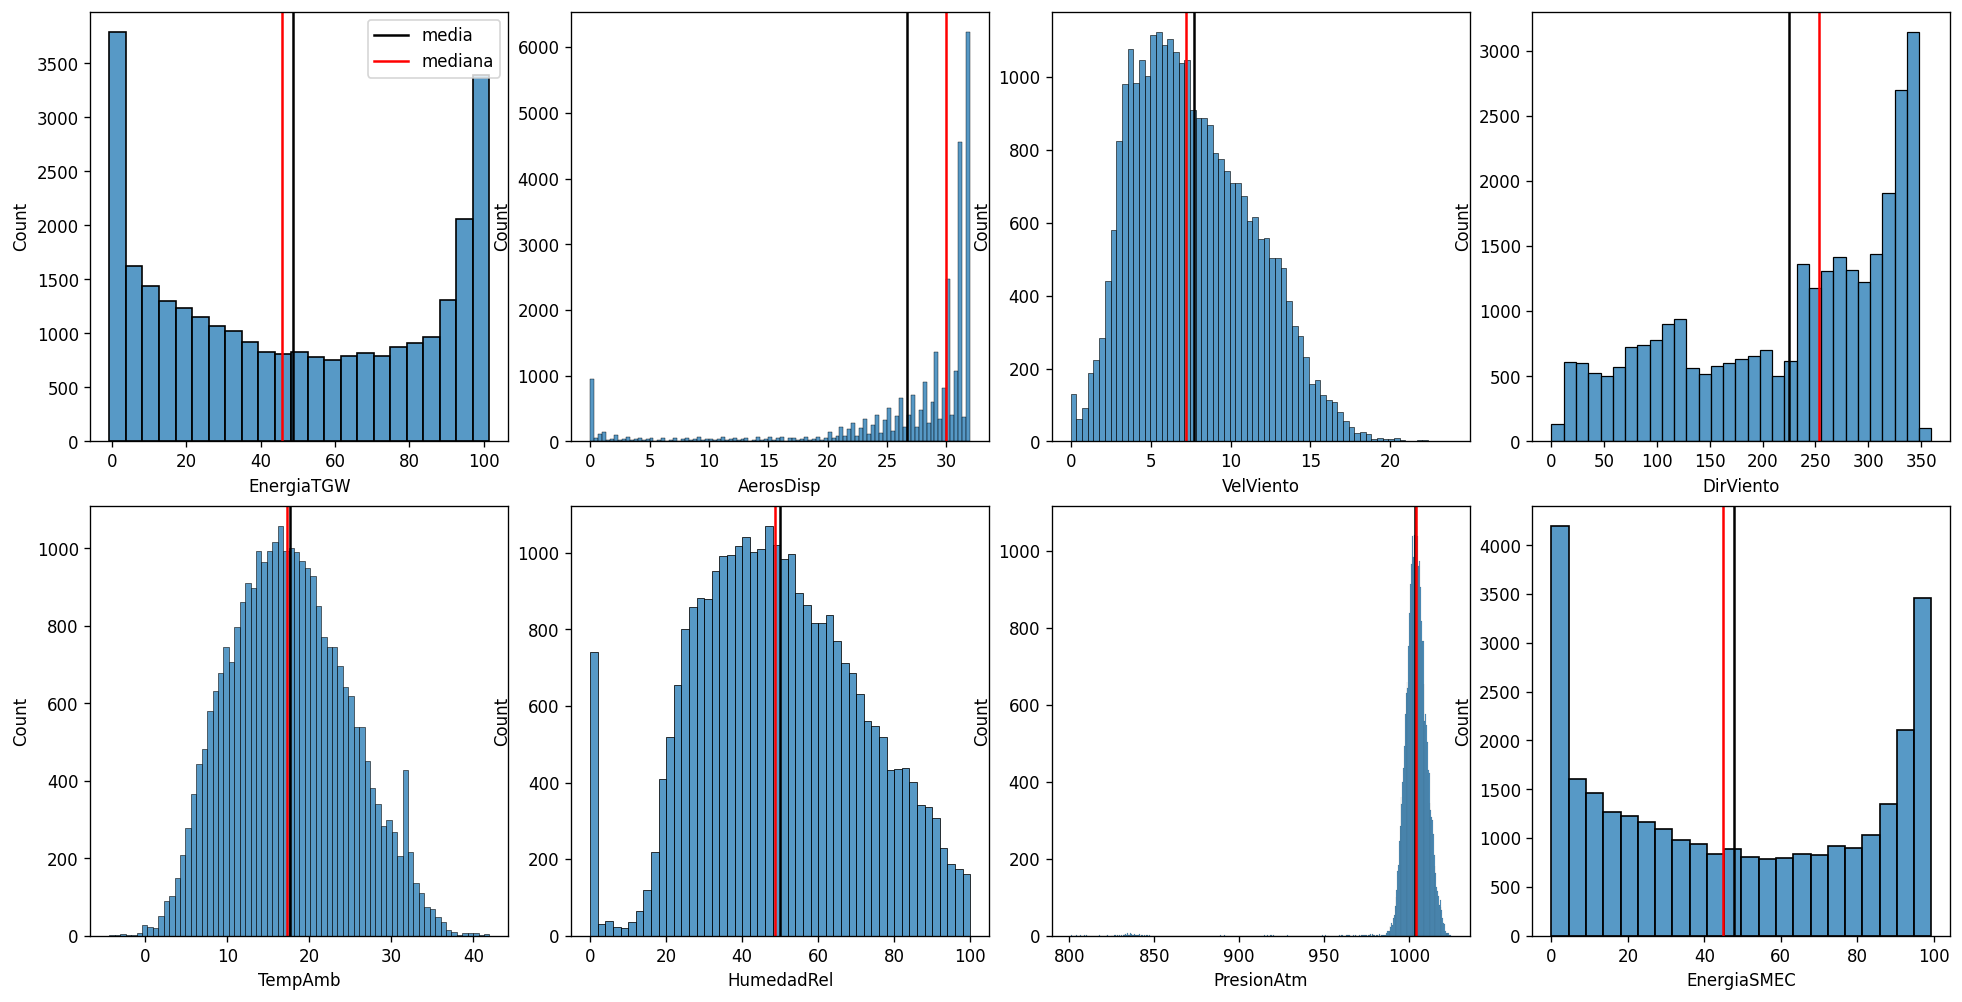

In [30]:
# Distribuciones para cada variable numerica
f, ax = plt.subplots(2, 4, figsize=(20, 10), gridspec_kw={'wspace': 0.15, 'hspace': 0.15})
ax = ax.ravel()

for i, col in enumerate(num_vars):
    sns.histplot(df_aux[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=df_aux[col].mean(), color='k', label='media')
    ax[i].axvline(x=df_aux[col].median(), color='r', label='mediana')

# Turn off the last subplot if needed
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()

ax[0].legend()


Luego de remover valores inconsistentes y outliers, no se observan en los histogramas outliers o picos que respondan a anomalias

##### Calculo de los promedios de las variables meteorológicas

In [31]:
# Discretizo la EnergiaSMEC con pasos de 0.5 MW
df['EnergiaSMEC_discreta'] = df['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)
df_aux['EnergiaSMEC_discreta'] = df_aux['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)

In [32]:
# Calculo la media de cada columna basado en los valores discretos de EnergiaProd
df_meteo = df_aux[['EnergiaSMEC_discreta','AerosDisp','VelViento','DirViento','TempAmb', 'HumedadRel', 'PresionAtm']]

df_mean_meteo = df_meteo.groupby('EnergiaSMEC_discreta').mean().reset_index()

df_count_meteo = df_meteo.groupby('EnergiaSMEC_discreta').count().reset_index()

In [33]:
# Calcula el promedio circular ponderado por la VelViento agrupando por EnergySMEC
DirViento_grouped_means = df_meteo.groupby('EnergiaSMEC_discreta').apply(lambda x: weighted_circular_mean(x['DirViento'], x['VelViento']), include_groups=False)

# Alinea la media calculada cob el index de df_mean_meteo
df_mean_meteo['DirViento'] = df_mean_meteo['EnergiaSMEC_discreta'].map(DirViento_grouped_means)


In [ ]:
#df_mean_meteo

In [ ]:
#df_count_meteo

In [34]:
# Realizo la unión de los DataFrames en base a las columna 'EnergiaSMEC_discreta'
merged_df = df.merge(df_mean_meteo, 
                 on=['EnergiaSMEC_discreta'], 
                 how='left', suffixes = ('', '_mean'))

In [35]:
#Imputo la media en los registros nulos
mask = merged_df[meteo_vars].isnull().all(axis=1)

# Imputo en los registors nulos de las variables meteorologicas los valores medios
merged_df.loc[mask, 'AerosDisp'] = merged_df.loc[mask, 'AerosDisp_mean']
merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']

# Imputo en los registors nulos de EnergiaTGW el valor medio 

merged_df['EnergiaTGW']=merged_df['EnergiaTGW'].fillna(merged_df['EnergiaTGW'].mean())


In [36]:
#verifico si quedo algun valor nulo
merged_df.isnull().sum()

FechaHora                   0
EnergiaTGW                  0
AerosDisp                   0
VelViento                   0
DirViento                   0
TempAmb                     0
HumedadRel                  0
PresionAtm                  0
EnergiaSMEC                 0
PronosticoCammesa       13026
ErrorPronostico         13026
EnergiaSMEC_discreta        0
AerosDisp_mean              0
VelViento_mean              0
DirViento_mean              0
TempAmb_mean                0
HumedadRel_mean             0
PresionAtm_mean             0
dtype: int64

In [37]:
# Utilizo la funcion rango_fechas_repe devuelve un data_range con los periodos de fecha 
# con valores repetidos en VelViento

dr=rango_fechas_repe(df, 'FechaHora', 'VelViento', 3,'y')

Existen 8655 registros repetidos
Valor 11.21 repetido 9 veces en las fechas: 2019-05-05 00:00:00 - 2019-05-05 08:00:00
Valor 3.55 repetido 12 veces en las fechas: 2019-05-07 21:00:00 - 2019-05-08 08:00:00
Valor 9.41 repetido 10 veces en las fechas: 2019-05-09 00:00:00 - 2019-05-09 09:00:00
Valor 4.07 repetido 17 veces en las fechas: 2019-05-09 18:00:00 - 2019-05-10 10:00:00
Valor 5.84 repetido 10 veces en las fechas: 2019-05-10 19:00:00 - 2019-05-11 04:00:00
Valor 6.68 repetido 3 veces en las fechas: 2019-05-11 06:00:00 - 2019-05-11 08:00:00
Valor 3.07 repetido 9 veces en las fechas: 2019-05-20 17:00:00 - 2019-05-21 01:00:00
Valor 3.07 repetido 4 veces en las fechas: 2019-05-21 05:00:00 - 2019-05-21 08:00:00
Valor 0.0 repetido 6 veces en las fechas: 2019-05-22 03:00:00 - 2019-05-22 08:00:00
Valor 4.21 repetido 11 veces en las fechas: 2019-05-30 00:00:00 - 2019-05-30 10:00:00
Valor 0.0 repetido 10 veces en las fechas: 2019-05-30 15:00:00 - 2019-05-31 00:00:00
Valor 0.0 repetido 4 veces 

In [38]:
#Imputo el valor medio de las variables meteorologicas para los rangos de fechas donde 
#hay valores repetidos
for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (merged_df['FechaHora'] >= start) & (merged_df['FechaHora'] <= end)

        # Actualizo los valores medios
        merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
        merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
        merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
        merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
        merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']


In [39]:
#Imputo la media en los registros de outliers de TempAmb
mask = (merged_df['TempAmb'] <= -5) | (merged_df['TempAmb'] >= 40)

merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']

#Imputo media en los registros de outliers de PresionAtm
mask = (merged_df['PresionAtm'] <= 800) | (merged_df['PresionAtm'] >= 1000)

merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']

#Imputo media en los registros que todas las variables meteorologicas son 0
mask = (merged_df[meteo_vars] == 0).all(axis=1)

# Actualizo los valores medios para todas las variables meteorologicas
merged_df.loc[mask, 'VelViento'] = merged_df.loc[mask, 'VelViento_mean']
merged_df.loc[mask, 'DirViento'] = merged_df.loc[mask, 'DirViento_mean']
merged_df.loc[mask, 'TempAmb'] = merged_df.loc[mask, 'TempAmb_mean']
merged_df.loc[mask, 'HumedadRel'] = merged_df.loc[mask, 'HumedadRel_mean']
merged_df.loc[mask, 'PresionAtm'] = merged_df.loc[mask, 'PresionAtm_mean']


In [40]:
df_clean=merged_df.iloc[:,0:11]

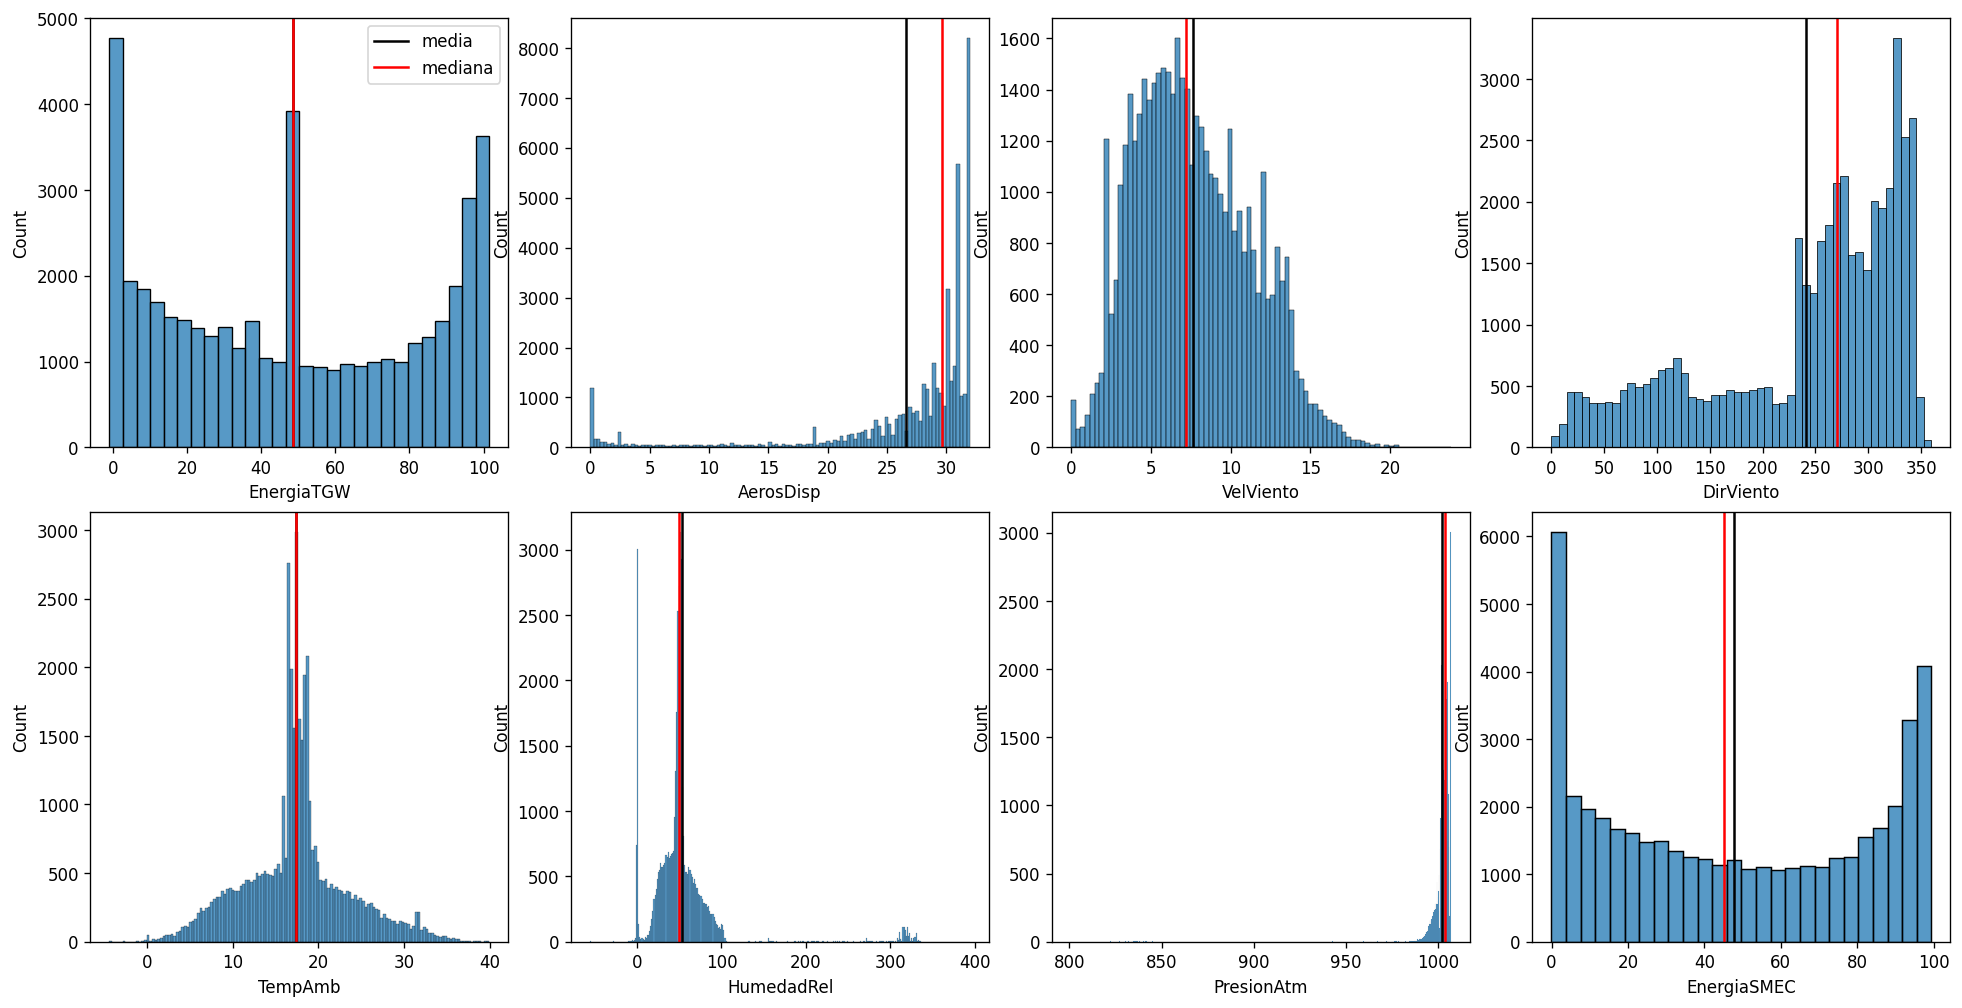

In [41]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.histplot(df_clean[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Como se puede observar en los histogramas el dataframe df_clean al reemplazar los valores inconsistentes de las variables metereológicas e imputarle la media en algunos casos se generan picos en las medias

<Axes: >

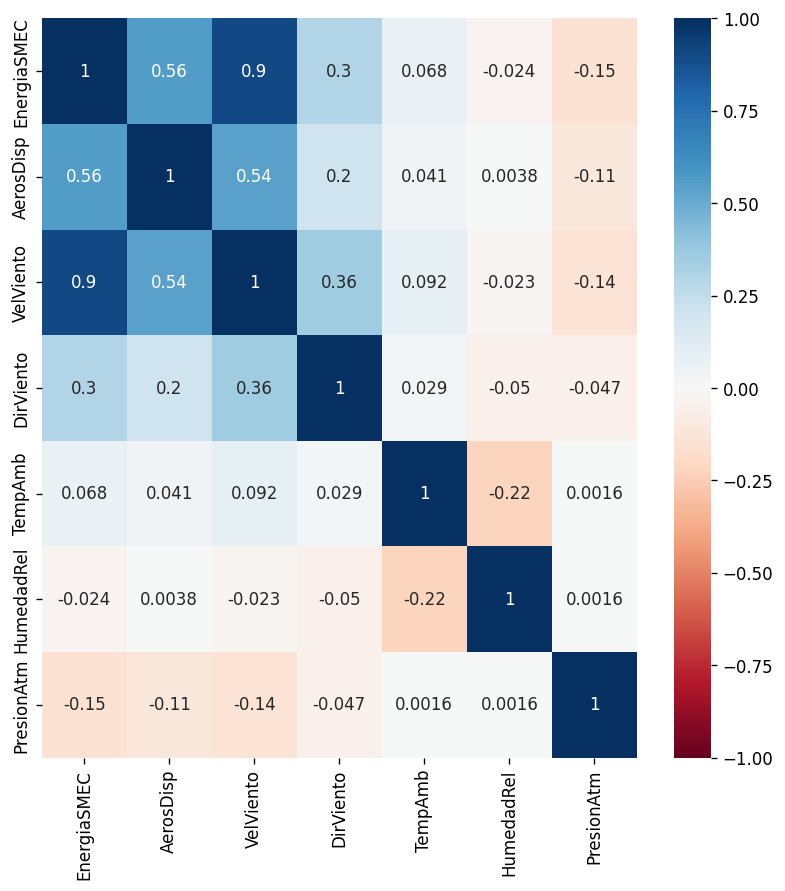

In [42]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','DirViento','TempAmb','HumedadRel','PresionAtm']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

En la matriz de correlacion se observa claramente la fuerte correlacion entre la Genracion y la velocidad del viento y los Aerogeneradores disponibles, en menor medida la direccion y aun menor la temperatura. Lo cual es totalmente razonable la correlacion con las variables de viento y disponibilidad de maquina, en el caso de la temperatura ambiente la correlacion esta asociada a lo que se conoce en la practica como derrating de temperatura perdida de eficiencia a medida que aumenta la temperatura 

In [ ]:
#dejo el archivo en un csv para analizar los datos limpios
#df_clean.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_lac.csv', sep=';', index=False, decimal=',')

In [43]:
df_clean.shape

(46050, 11)

### Extraccion de datos climaticos historicos desde Meteostat 
Se toman de la estación meteorologica del Aerodromo de Bahia Blanca que se encuentra a 30 Km del PE La Castellana

In [44]:
# Get nearby weather stations
stations = Stations()

#Aerodromo de Bahia Blanca a 30 Km de La Castellana I
station_ba = stations.nearby(-38.7333, -62.1667) 
station_ba = station_ba.fetch(1)

# Print DataFrame
print(station_ba)

                         name country region    wmo  icao  latitude  \
id                                                                    
87750  Bahia Blanca Aerodrome      AR      B  87750  SAZB  -38.7333   

       longitude  elevation                        timezone hourly_start  \
id                                                                         
87750   -62.1667       75.0  America/Argentina/Buenos_Aires   1939-04-10   

      hourly_end daily_start  daily_end monthly_start monthly_end  distance  
id                                                                           
87750 2024-01-22  1956-02-02 2024-12-30    1956-01-01  2021-01-01       0.0  


In [45]:
# Set time period Mask
start = datetime(2019, 1, 2)
#end = datetime(2024, 3, 31)


# Calcula end_date como la fecha actual + 11 días para incluir datos del pronostico
current_date = datetime.now().date()
end_date = current_date + timedelta(days=11)

# Convierte a datetime con la hora establecida a medianoche
end = datetime.combine(end_date, datetime.min.time())

print("End date:", end)

End date: 2024-04-13 00:00:00


In [46]:
# Create Point for Bahia Blanca
station_ba = 87750  

# Get daily data Bahia Blanca
data_met_ba = Hourly(station_ba, start, end)
#data_met_ba = data_met_ba.normalize()
data_met_ba = data_met_ba.fetch()

# Time Zone Correction Subtract 3 hours from the DateTimeIndex - UTC Buenos Aires
data_met_ba.index = data_met_ba.index - pd.to_timedelta(3, unit='h')

#Wind speed esta en Km/h lo convierto a m/s
data_met_ba['wspd_ms'] = (data_met_ba['wspd'] / 3.6).round(1)


data_met_ba = data_met_ba[[ 'wspd_ms', 'wdir', 'temp','pres','rhum']]

data_met_ba.tail()

,wspd_ms,wdir,temp,pres,rhum
time,,,,,
2024-04-11 03:00:00,3.1,355.0,10.0,1017.3,99.0
2024-04-11 04:00:00,3.1,353.0,9.8,1017.2,99.0
2024-04-11 05:00:00,3.1,351.0,9.7,1017.1,99.0
2024-04-11 06:00:00,3.1,352.0,9.6,1017.1,98.0
2024-04-11 07:00:00,3.1,353.0,10.0,1017.9,97.0


In [47]:
data_met_ba.index.name = 'FechaHora'

In [48]:
# Realizo la unión de los DataFrames

df_clean_met = data_met_ba.merge(df_clean, 
                 on=['FechaHora'],
                 how='left')


In [ ]:
#df_clean_met.tail(40)

In [49]:
df_clean_met.shape

(46235, 16)

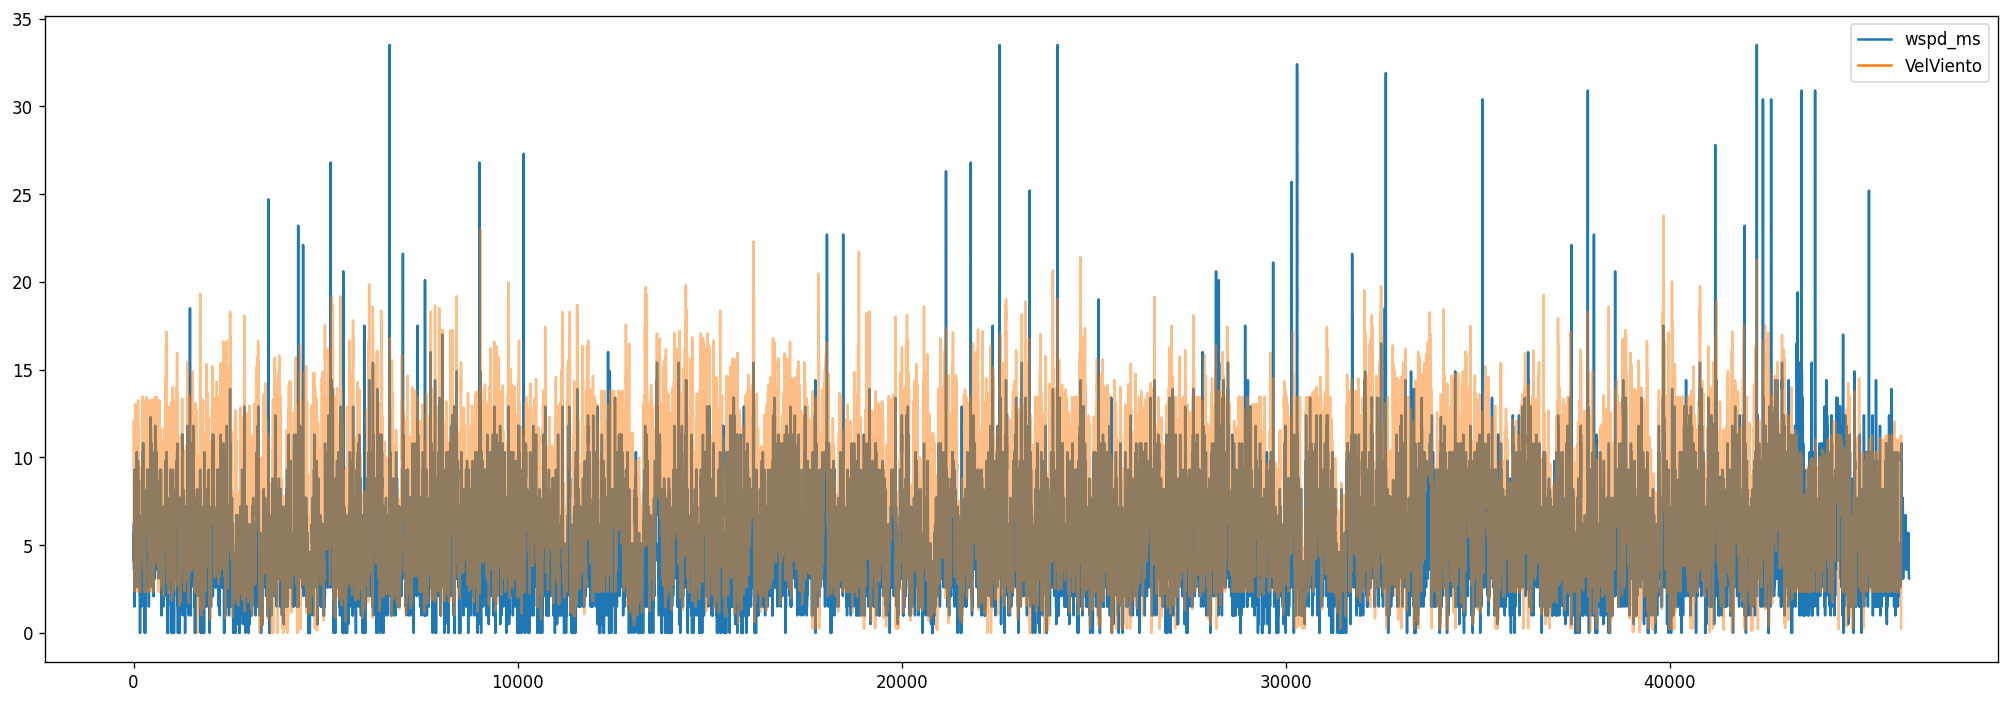

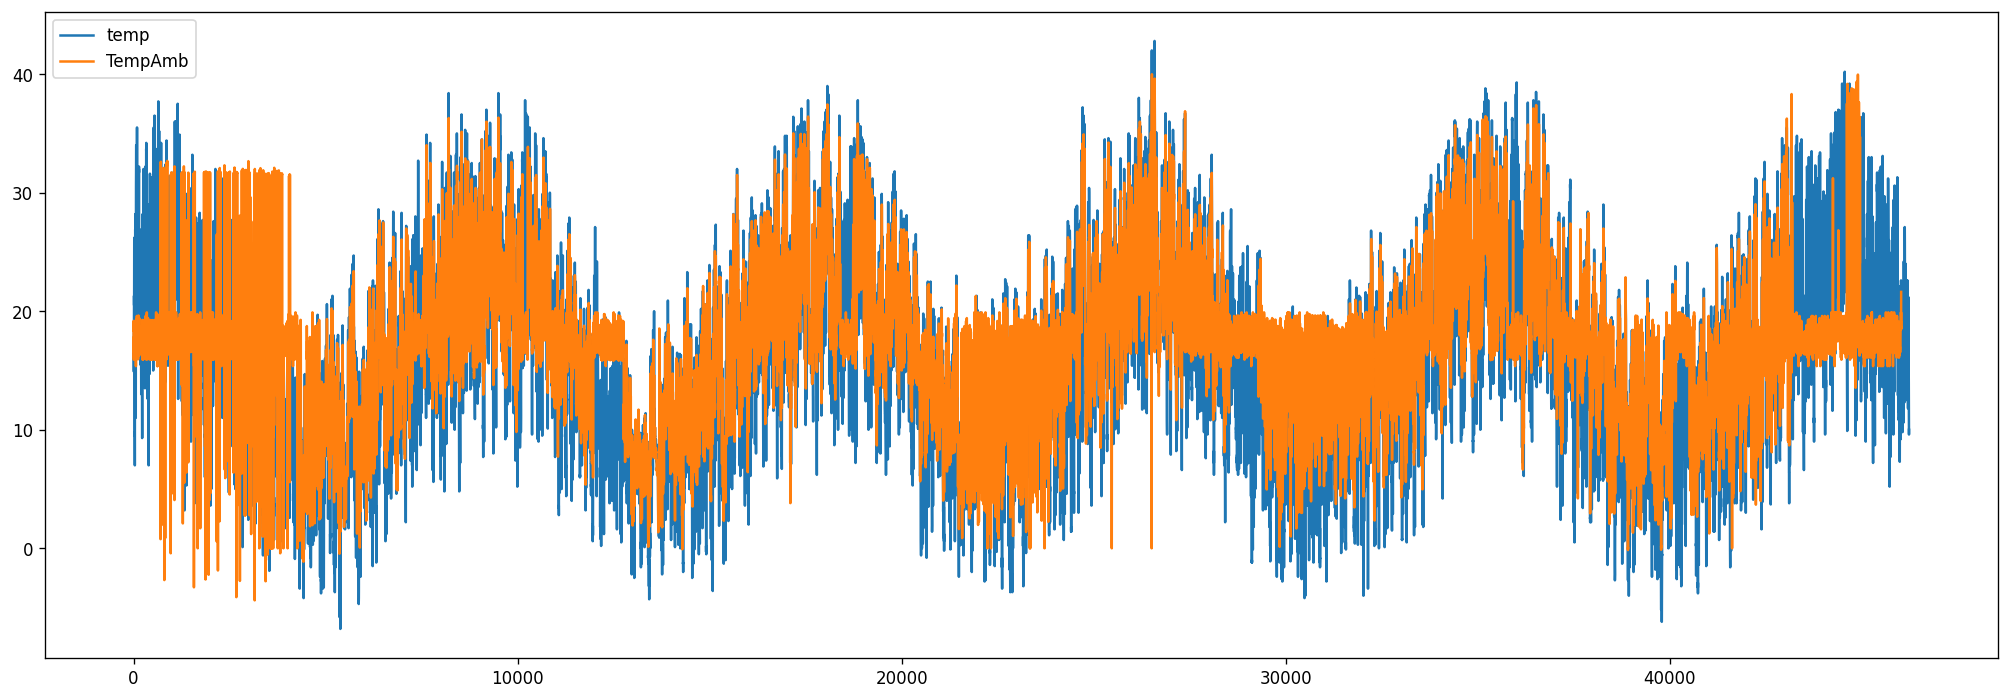

In [50]:
# Plotting specific columns
ax = df_clean_met.plot(y=['wspd_ms', 'VelViento'])  # Plot both columns

# Adjusting the transparency of a specific line (VelViento) after plotting
lines = ax.get_lines()  # Get the lines in the plot
lines[1].set_alpha(0.5)  # Set transparency (alpha) of the second line (VelViento) to 0.5

df_clean_met.plot(y=['temp','TempAmb'])

plt.show()

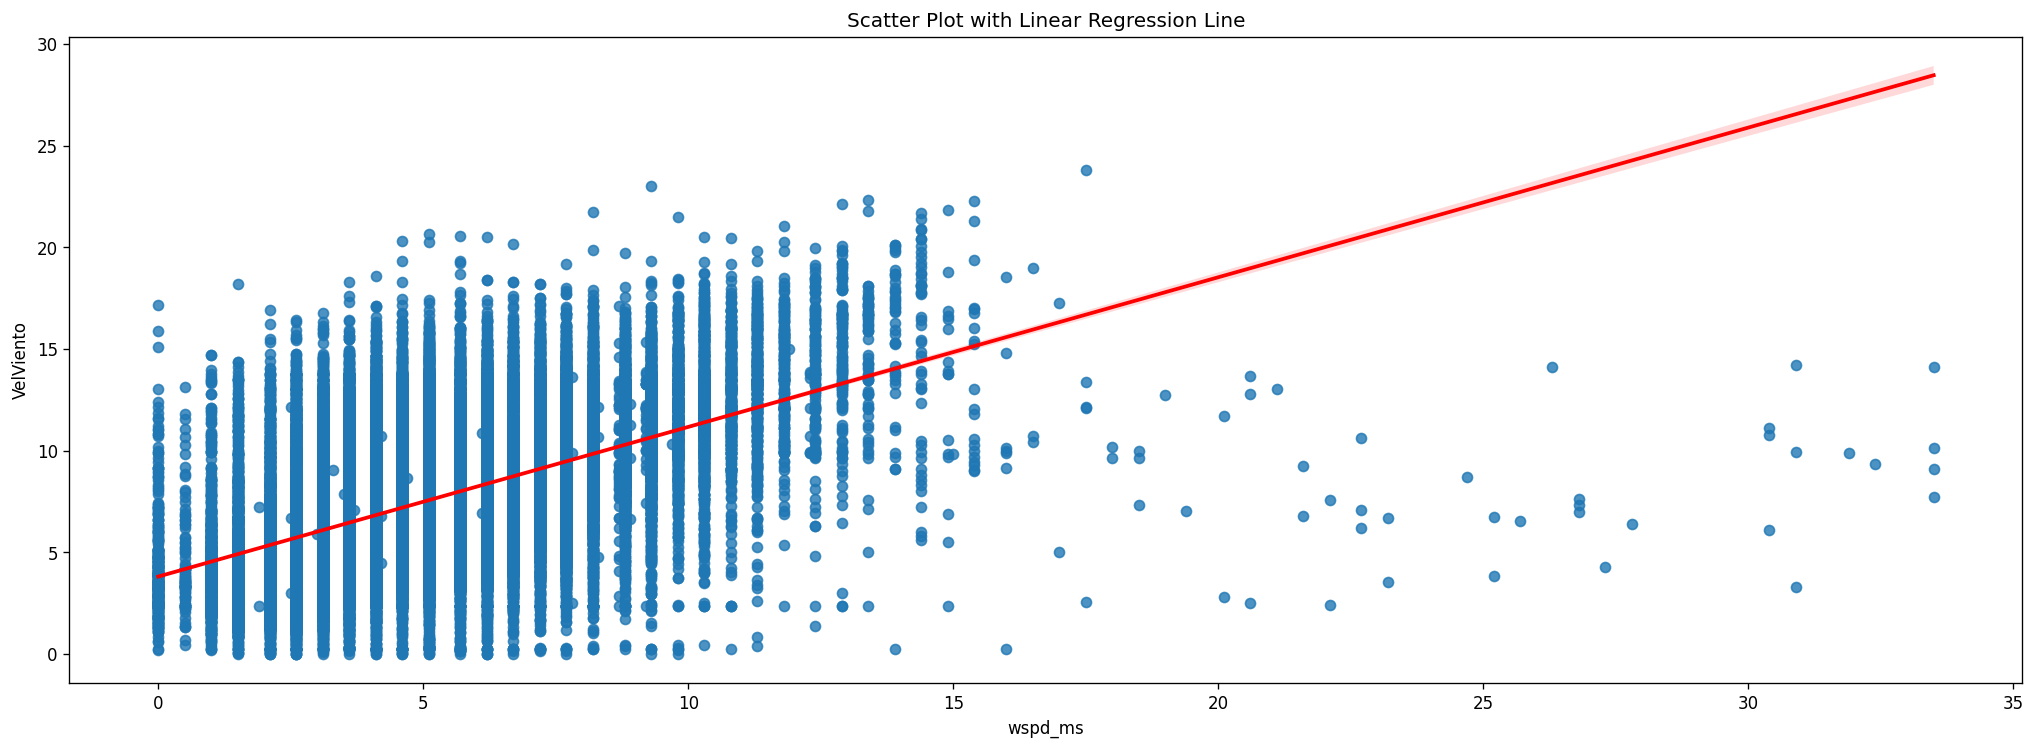

In [51]:
# Scatter plot
sns.regplot(x='wspd_ms', y='VelViento', data=df_clean_met, line_kws={'color': 'red'})
plt.xlabel('wspd_ms')
plt.ylabel('VelViento')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()


#### Distribucion de la velocidad de viento (wspd_ms) extraida de MeteoStat para Bahia Blanca

<Axes: xlabel='wspd_ms', ylabel='Count'>

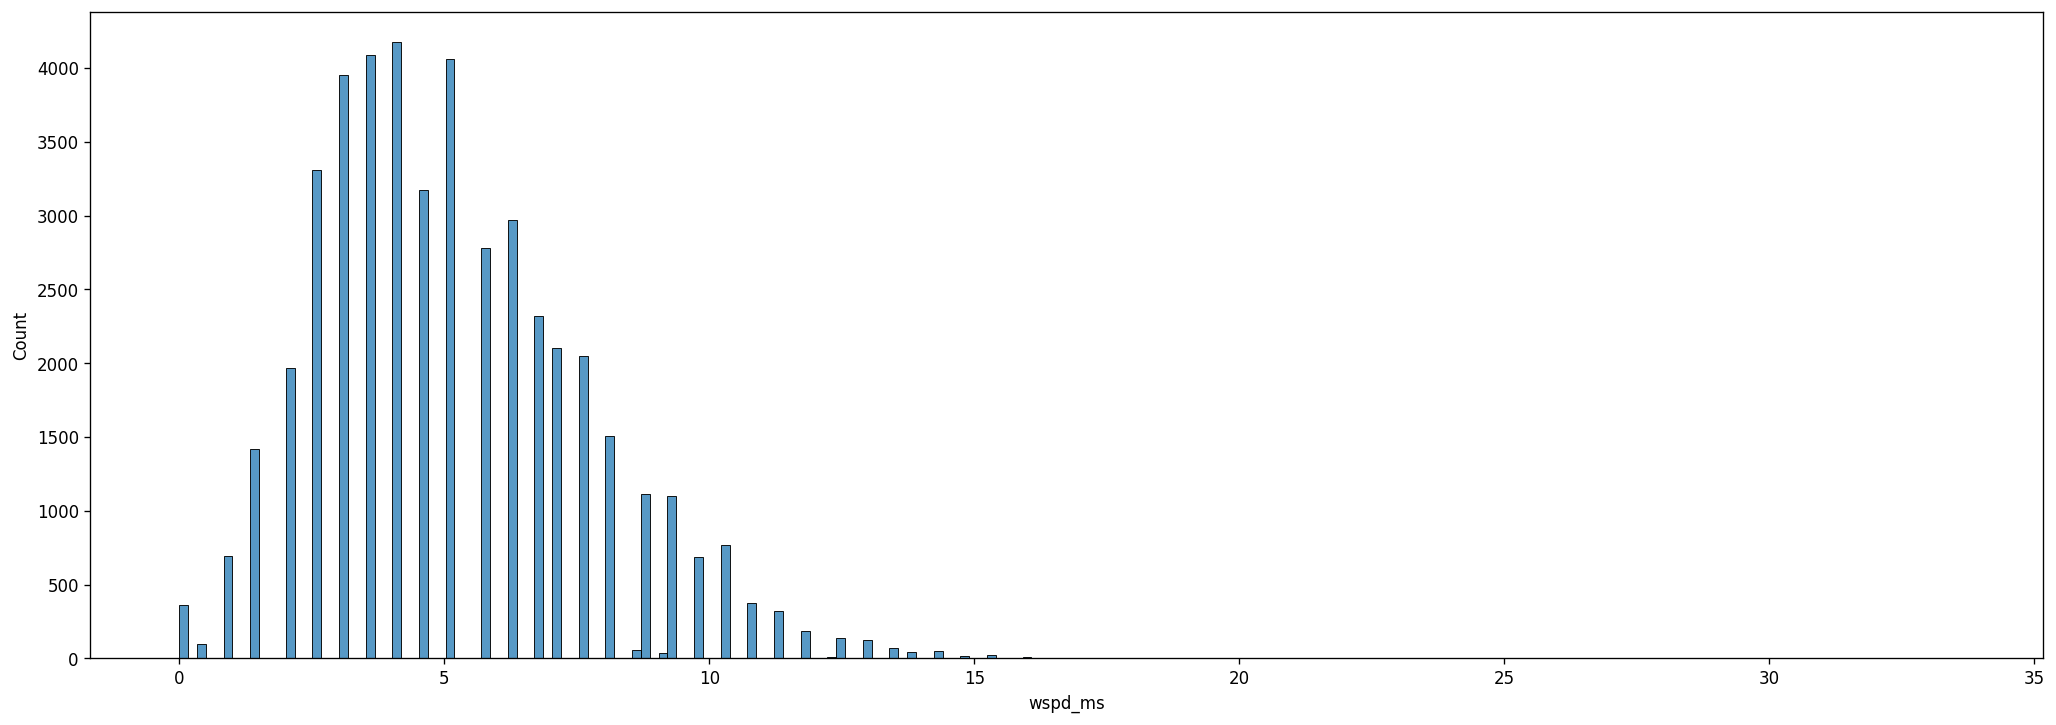

In [52]:
sns.histplot(data_met_ba['wspd_ms'].astype(float),kde=False, bins=200)

#### Distribucion de la velocidad de viento (VelViento) del parque La Castellana

<Axes: xlabel='VelViento', ylabel='Count'>

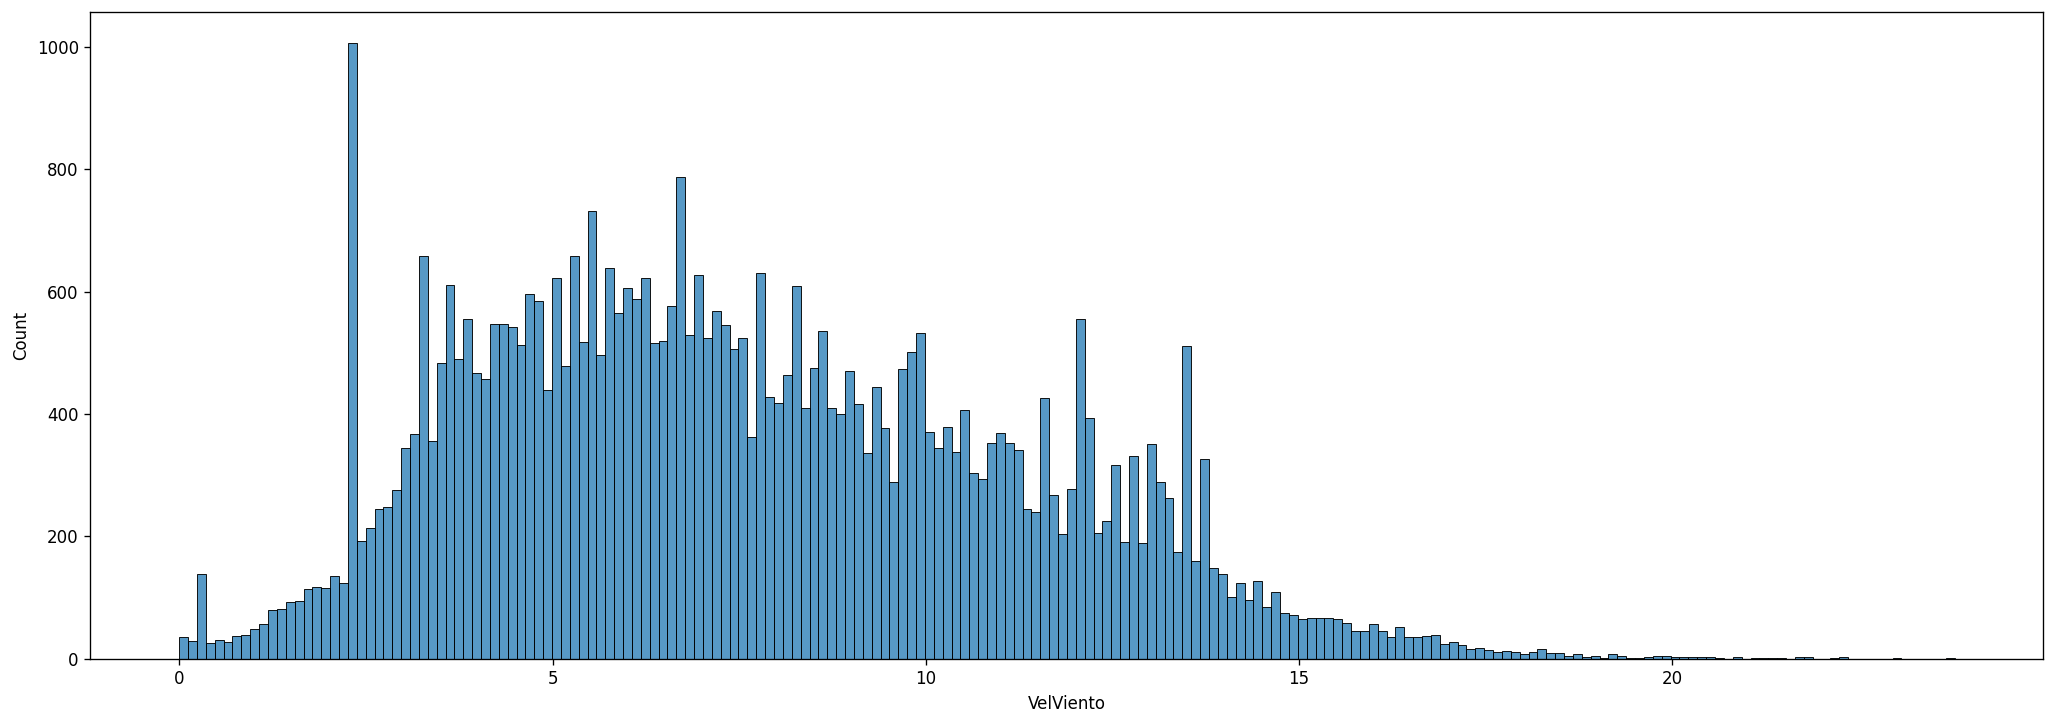

In [53]:
sns.histplot(df_clean['VelViento'].astype(float),kde=False, bins=200)

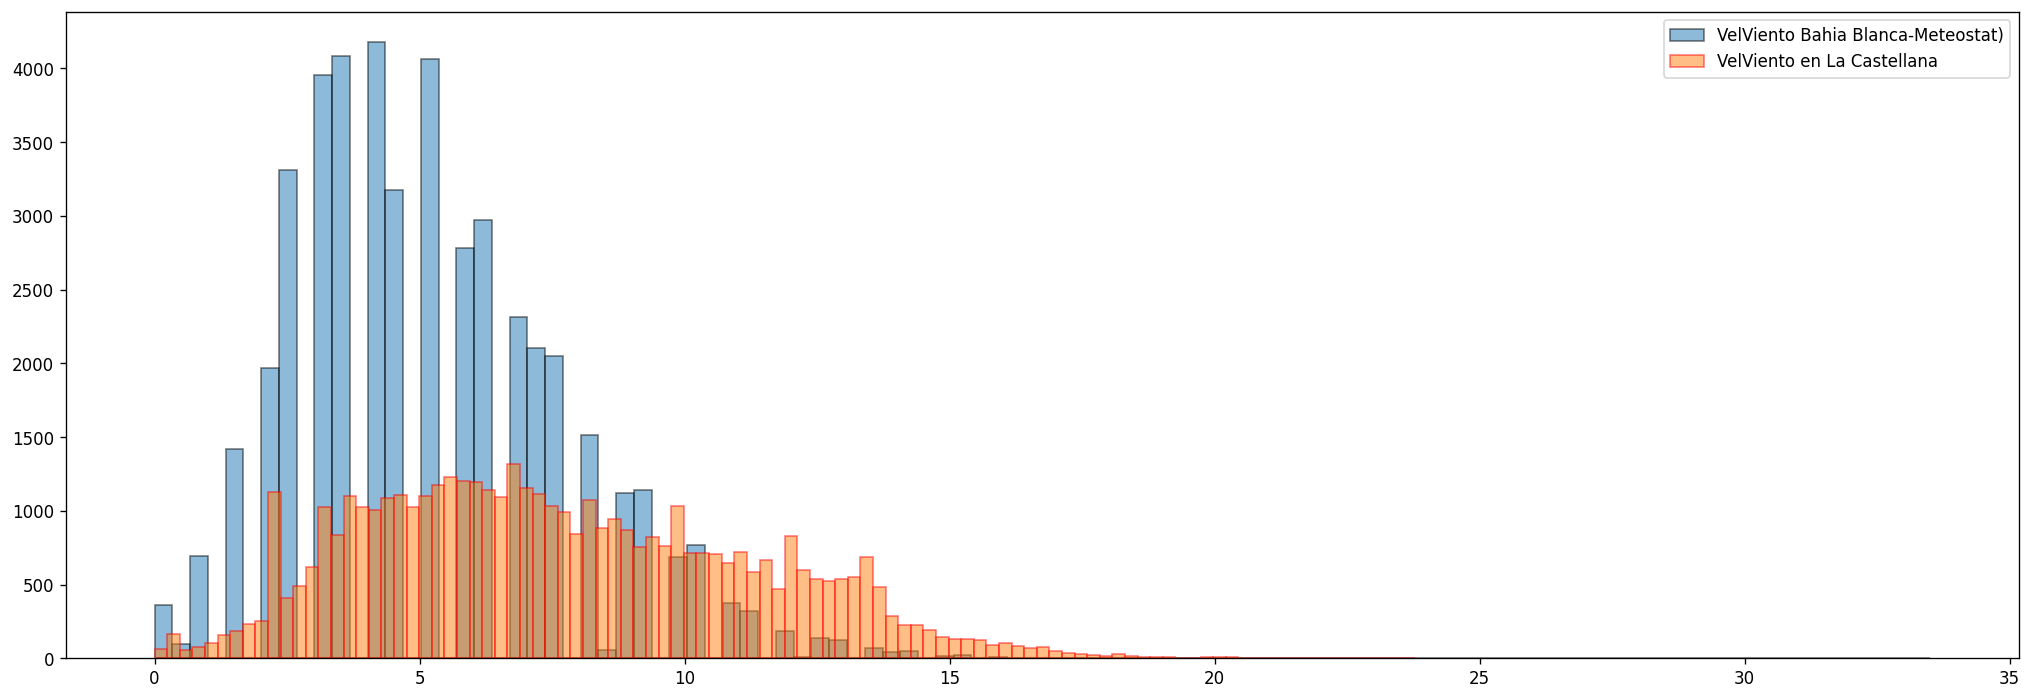

In [54]:
plt.hist(df_clean_met['wspd_ms'], edgecolor='black', alpha=0.5, label='VelViento Bahia Blanca-Meteostat)', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_met['VelViento'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

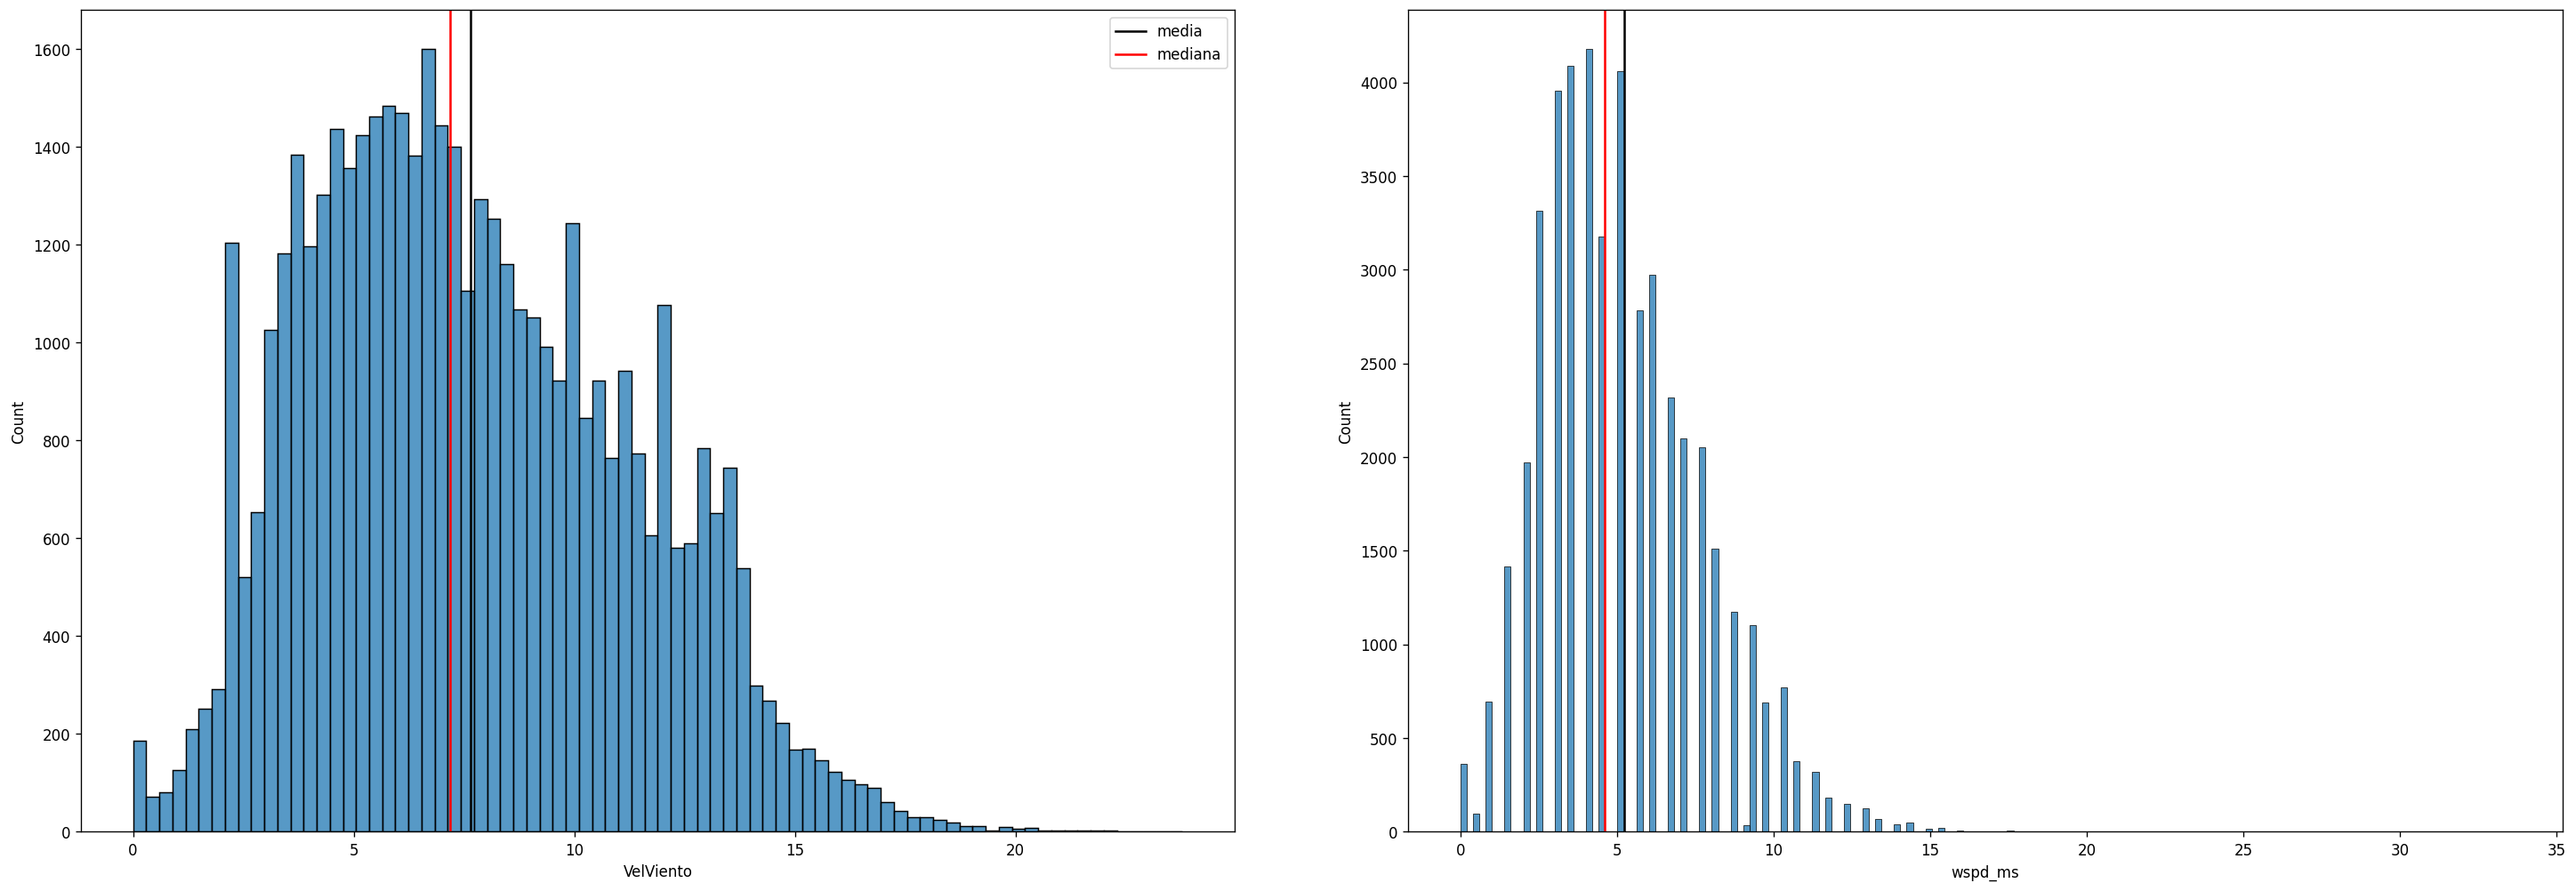

In [55]:
num_vars_met = ['VelViento','wspd_ms'] #,'wspd_ms_rc_ajus'

# Distribuciones para cada variable numerica
f,ax = plt.subplots(1,2,figsize=(30,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars_met):
    sns.histplot(df_clean_met[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean_met[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean_met[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

<Axes: >

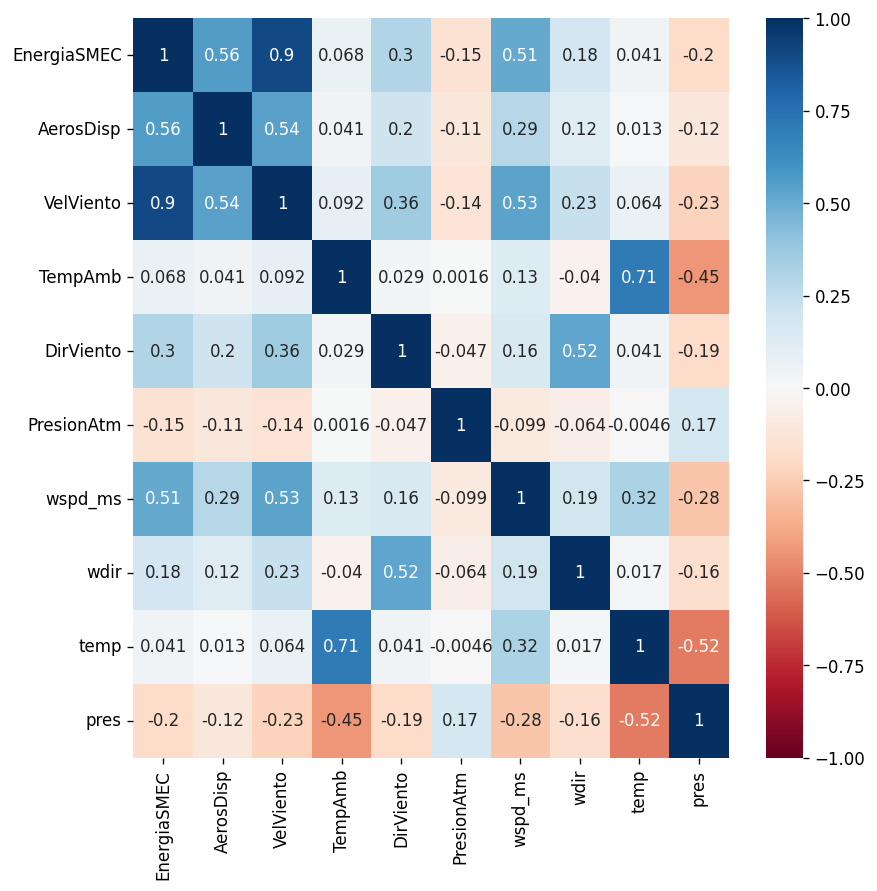

In [56]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_met[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

In [57]:
corr_matrix = df_clean_met[key_vars].corr()
corr_matrix['EnergiaSMEC'].sort_values(ascending=False)

EnergiaSMEC    1.000000
VelViento      0.898473
AerosDisp      0.561727
wspd_ms        0.510588
DirViento      0.299162
wdir           0.180847
TempAmb        0.067599
temp           0.041176
PresionAtm    -0.151713
pres          -0.195217
Name: EnergiaSMEC, dtype: float64

##### Se reduce el dataset a las variables de interes 

In [58]:
df_clean_ba=df_clean_met[['FechaHora','EnergiaSMEC','AerosDisp','VelViento','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres','rhum']]

In [59]:
df_clean_ba.tail()

,FechaHora,EnergiaSMEC,AerosDisp,VelViento,TempAmb,DirViento,PresionAtm,wspd_ms,wdir,temp,pres,rhum
46230,2024-04-11 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.1,355.0,10.0,1017.3,99.0
46231,2024-04-11 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.1,353.0,9.8,1017.2,99.0
46232,2024-04-11 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.1,351.0,9.7,1017.1,99.0
46233,2024-04-11 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.1,352.0,9.6,1017.1,98.0
46234,2024-04-11 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.1,353.0,10.0,1017.9,97.0


In [60]:
df_clean_rl=df_clean_ba.copy()
df_clean_rl.dropna(inplace=True)
df_clean_rl.tail()

,FechaHora,EnergiaSMEC,AerosDisp,VelViento,TempAmb,DirViento,PresionAtm,wspd_ms,wdir,temp,pres,rhum
46025,2024-04-02 14:00:00,87.20,30.00,11.254762,19.906122,319.484800,1002.609728,9.8,352.0,22.3,1008.6,43.0
46026,2024-04-02 15:00:00,86.72,29.50,11.133561,18.745000,318.674379,1001.709697,10.3,352.0,22.6,1007.4,42.0
46027,2024-04-02 16:00:00,84.58,29.83,10.442370,18.459926,307.525240,1003.325185,10.3,355.0,22.4,1005.9,43.0
46028,2024-04-02 17:00:00,80.92,29.17,9.859752,18.748264,312.171785,1003.956364,10.3,356.0,22.0,1005.2,45.0
46029,2024-04-02 18:00:00,69.88,28.50,0.250000,21.630000,344.330000,992.570000,9.8,356.0,20.9,1003.8,50.0


### Regresión Lineal Multiple (MLR) para predecir Vel Viento en el Parque LC en función de las variables meteorologicas en Bahia Blanca

In [61]:
dataset_mlr = df_clean_rl[['VelViento','wspd_ms','wdir','temp','pres']]

Se experimentan diferentes alternativas de combinación entre los features de 'wspd_ms','wdir'

In [62]:
# Separate features (X) and target variable (y)
X = dataset_mlr[['wspd_ms','wdir','temp','pres']]
y = dataset_mlr['VelViento']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a dictionary to store MSE and R2 for different feature combinations
mse_r2_dict = {}

# Define function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# 1. Using wind speed and direction separately
lr_separate = LinearRegression()
lr_separate.fit(X_train, y_train)
mse_r2_dict['Separate'] = evaluate_model(lr_separate, X_test, y_test)

# 2. Creating interaction terms
X_train_interaction = X_train.copy()
X_test_interaction = X_test.copy()
X_train_interaction['Wind Speed * Direction'] = X_train_interaction['wspd_ms'] * X_train_interaction['wdir']
X_test_interaction['Wind Speed * Direction'] = X_test_interaction['wspd_ms'] * X_test_interaction['wdir']
lr_interaction = LinearRegression()
lr_interaction.fit(X_train_interaction, y_train)
mse_r2_dict['Interaction'] = evaluate_model(lr_interaction, X_test_interaction, y_test)

# 3. Utilizing transformed versions of wind direction (sine and cosine components)
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()
X_train_transformed['Wind Direction (sin)'] = X_train_transformed['wdir'].apply(lambda x: np.sin(np.radians(x)))
X_train_transformed['Wind Direction (cos)'] = X_train_transformed['wdir'].apply(lambda x: np.cos(np.radians(x)))
X_test_transformed['Wind Direction (sin)'] = X_test_transformed['wdir'].apply(lambda x: np.sin(np.radians(x)))
X_test_transformed['Wind Direction (cos)'] = X_test_transformed['wdir'].apply(lambda x: np.cos(np.radians(x)))
lr_transformed = LinearRegression()
lr_transformed.fit(X_train_transformed, y_train)
mse_r2_dict['Transformed'] = evaluate_model(lr_transformed, X_test_transformed, y_test)

# 4. Experimenting with different polynomial degrees
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
mse_r2_dict['Polynomial'] = evaluate_model(lr_poly, X_test_poly, y_test)

# Print MSE and R2 for different feature combinations
print("Performance for Different Feature Combinations:")
for feature_combination, (mse, r2) in mse_r2_dict.items():
    print(f"{feature_combination}: MSE={mse}, R2={r2}")


Performance for Different Feature Combinations:
Separate: MSE=8.512439348152716, R2=0.3372642029023122
Interaction: MSE=8.246052625025396, R2=0.35800373596298973
Transformed: MSE=7.182810010923043, R2=0.44078246865590076
Polynomial: MSE=6.181693046734351, R2=0.518724410103459


El menor MSE se da para la alternativa Polynomial, seleccionamos esta opción y seguimos profundizando en el analisis

##### Busco el grado del polinomio que da el menor MSE sin Overfitting

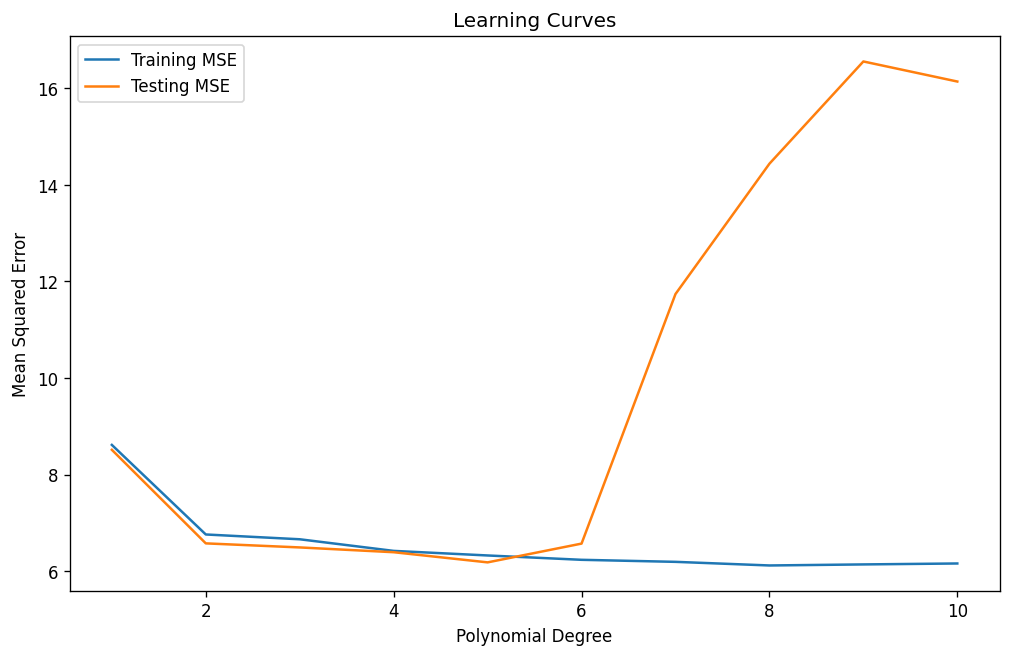

In [63]:
# Initialize lists to store training and testing MSE for different polynomial degrees
train_mse = []
test_mse = []

# Try polynomial degrees from 1 to max_degree
max_degree = 10
for degree in range(1, max_degree+1):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Evaluate model on training and testing sets
    train_mse.append(mean_squared_error(y_train, model.predict(X_train_poly)))
    test_mse.append(mean_squared_error(y_test, model.predict(X_test_poly)))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_degree+1), train_mse, label='Training MSE')
plt.plot(range(1, max_degree+1), test_mse, label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves')
plt.legend()
plt.show()


##### El grado de polinomio 4 parece tener el menor MSE sin que se separen las curvas de Train y Test

In [64]:
#Entreno el modelo con un polinomio de grado5
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

LinearRegression()

In [69]:
#Prediccion de la velocidad para todo el dataset
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(df_clean_ba[['wspd_ms','wdir','temp','pres']])
df_clean_ba['Vel_Viento_pred']= lr_poly.predict(X_poly)

In [70]:
# Set Vel_Viento_pred to 0 if its predicted value is less than 0
df_clean_ba['Vel_Viento_pred'] = np.where(df_clean_ba['Vel_Viento_pred'] < 0, 0, df_clean_ba['Vel_Viento_pred'])

<Axes: >

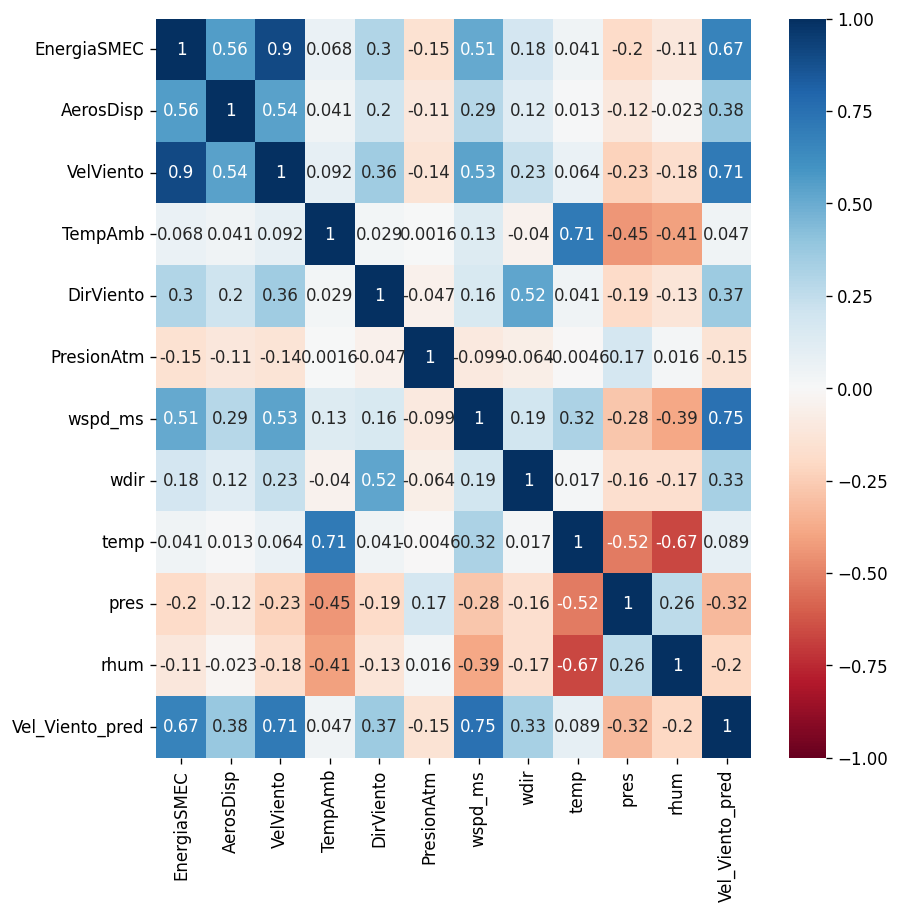

In [71]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','AerosDisp','VelViento','TempAmb','DirViento','PresionAtm','wspd_ms','wdir','temp','pres','rhum','Vel_Viento_pred']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_ba[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

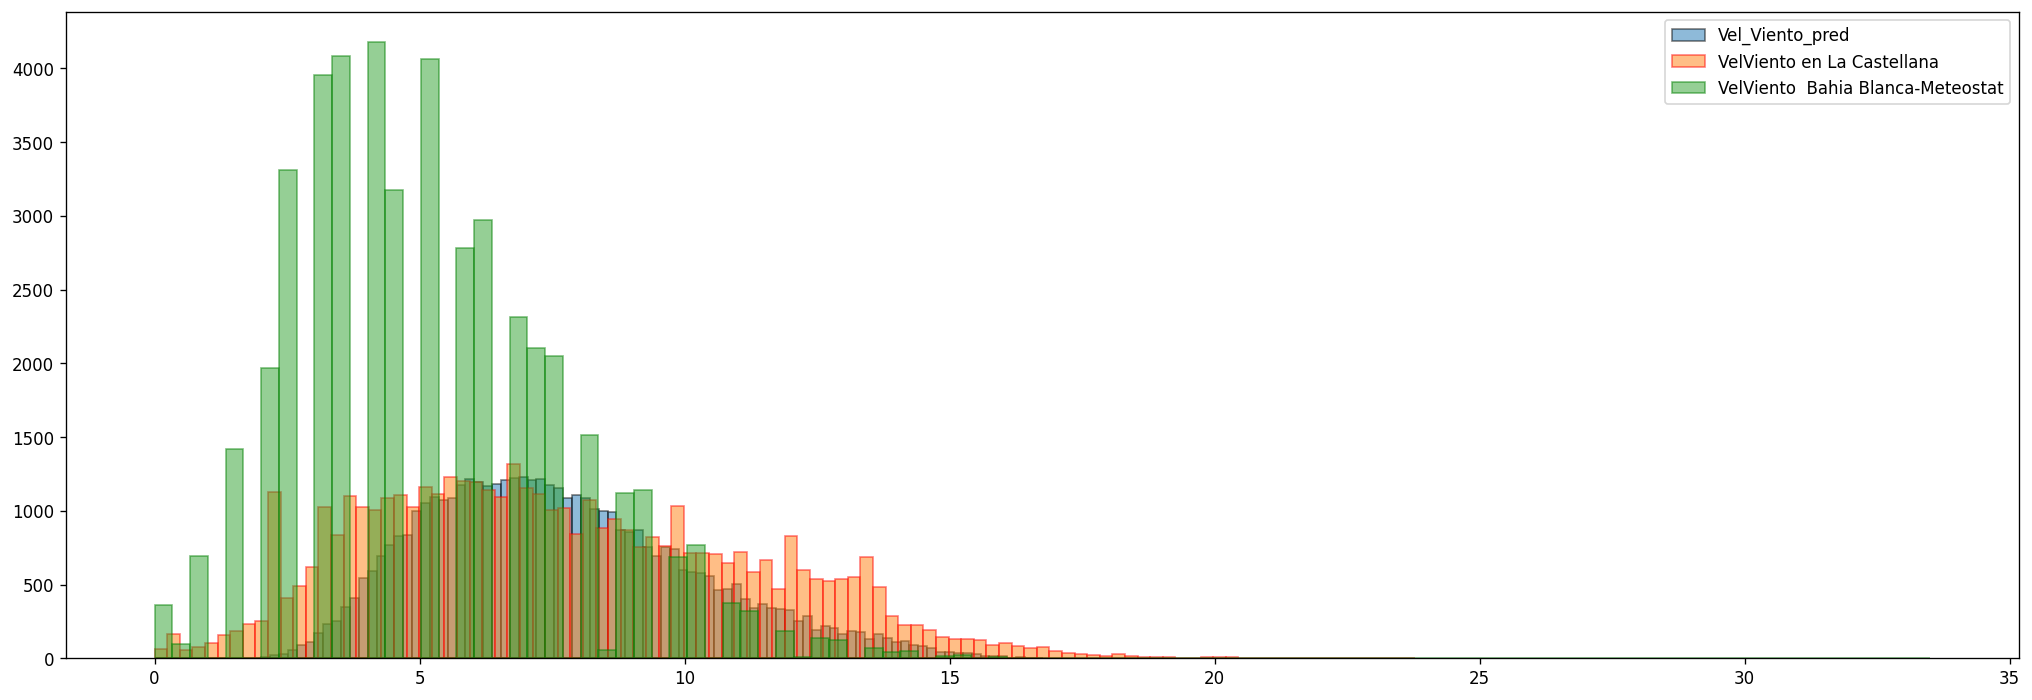

In [72]:
plt.hist(df_clean_ba['Vel_Viento_pred'], edgecolor='black', alpha=0.5, label='Vel_Viento_pred', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_ba['VelViento'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.hist(df_clean_ba['wspd_ms'], edgecolor='green', alpha=0.5, label='VelViento  Bahia Blanca-Meteostat', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

In [73]:
#Exporto el archivo del dataset limpio
df_clean_ba=df_clean_ba.round(2)
df_clean_ba.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_ba.csv', sep=';', index=False, decimal=',')